# The 3 steps to factor risk analysis
Quants use factors to target specific drivers of returns and manage risk. Diversification is great until the entire market declines in value. That’s because the market influences all stocks. Factors can offset some of these risks by targeting drivers of return not influenced by the market.

Common factors are size (large-cap versus small-cap) and style (value versus growth). If you think small-cap stocks will outperform large-cap stocks, then you might want exposure to small-cap stocks. If you think value stocks will outperform growth stocks, then you might want exposure to value stocks. In either case, you want to measure the risk contribution of the factor.


## Use the Fama-French factor model to measure risk exposure
Eugene Fama and Kenneth French built the Fama-French three-factor model in 1992. It’s a popular factor model you can use for free. The model includes size, style, and excess returns. You can read about the model on [Kenneth French’s website](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_factors.html). For this analysis, I will show you how to use the size and style factors.


## Step 1: Download historic factor data
First, import the libraries. You can use pandas_datareader to download the factor data and yfinance to download stock price data. <br> Use statsmodels for modeling.

In [1]:
import numpy as np
import pandas as pd

import pandas_datareader as pdr
from openbb_terminal.sdk import openbb

import statsmodels.api as sm
from statsmodels import regression
from statsmodels.regression.rolling import RollingOLS

Download the data.

In [2]:
factors = pdr.get_data_famafrench(
    'F-F_Research_Data_Factors',
    start='2000-01-01'
)[0][1:]

SMB = factors.SMB
HML = factors.HML

SMB is “small minus big” representing the size factor. HML is “high minus low” representing the style factor. This also downloads a third factor, Rm-Rf, which is the market excess return. I only use SMB and HML for this analysis.

Now get the stock price data for your portfolio. You can pick any stocks you want. (Make sure to include a benchmark like SPY.)

In [17]:
symbols = ['SPY', 'MSFT', 'AAPL', 'INTC']

dfs = []
for symbol in symbols:
    data = openbb.stocks.load(symbol, start_date="2000-01-01", monthly=True)["Adj Close"]
    dfs.append(data)

data = pd.concat(dfs, axis=1)
data.columns = symbols

monthly_returns = data.pct_change().to_period("M")

Loading Daily data for SPY with starting period 2000-01-01.

Loading Daily data for MSFT with starting period 2000-01-01.

Loading Daily data for AAPL with starting period 2000-01-01.

Loading Daily data for INTC with starting period 2000-01-01.

The factor data is monthly so to align with the stock data, you need to get monthly closing prices and resample to monthly labels. pandas makes it easy.

## Step 2: Compute the sensitivities to the factors
Next, compute the active return of the portfolio. The active return is the portfolio return minus the benchmark return.

In [19]:
bench = monthly_returns.pop("SPY")
R = monthly_returns.mean(axis=1)
active = R - bench

“Pop” the benchmark return off the returns data frame. Then, calculate the portfolio returns and subtract the benchmark.

Use regression to compute the sensitivities to the factors.

In [20]:
df = pd.DataFrame({
    'R': active,
    'F1': SMB,
    'F2': HML,
}).dropna()

b1, b2 = regression.linear_model.OLS(
    df.R, 
    df[['F1', 'F2']]
).fit().params

print(f'Sensitivities of active returns to factors:\nSMB: {b1}\nHML: {b2}')

Sensitivities of active returns to factors:
SMB: 0.00237200595990562
HML: -0.0055782826850964765


Put the active returns and factors into a DataFrame to make it easy to align the dates. Then run a regression with the active returns as the dependent variable on the factors. Fitting the model gives you the two coefficients that determine the sensitivities of the portfolio’s active returns to the factors.

The sensitivities are estimates so it’s important to see how they evolve through time.



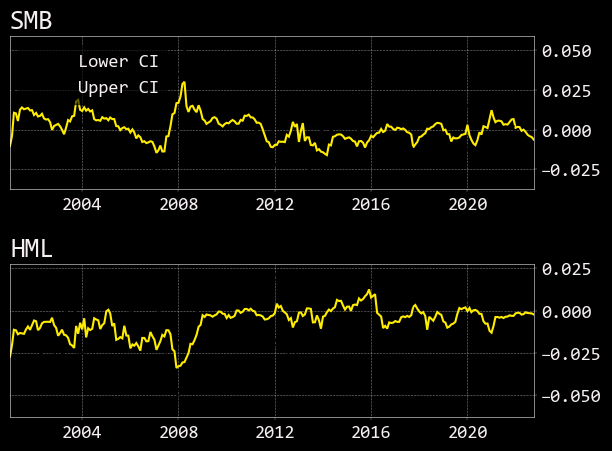

In [24]:
exog_vars = ["SMB", "HML"]
exog = sm.add_constant(factors[exog_vars])
rols = RollingOLS(df.R, exog, window=12)
rres = rols.fit()
fig = rres.plot_recursive_coefficient(variables=exog_vars)

The sensitivities tell you how much the active portfolio returns change in response to changes in the factors. In other words, how the factors drive the active portfolio returns.

## Step 3: Figure out the risk contribution of the factors
Marginal Contribution To Active Risk (MCTAR) measures the incremental active risk each additional factor introduces to your portfolio.

In [25]:
F1 = df.F1
F2 = df.F2

cov = np.cov(F1, F2)
ar_squared = (active.std())**2
mcar1 = (b1 * (b2 * cov[0,1] + b1 * cov[0,0])) / ar_squared
mcar2 = (b2 * (b1 * cov[0,1] + b2 * cov[1,1])) / ar_squared
print (f'SMB risk contribution: {mcar1}')
print (f'HML risk contribution: {mcar2}')
print (f'Unexplained risk contribution: {1 - (mcar1 + mcar2)}')

SMB risk contribution: 0.026341744201587424
HML risk contribution: 0.12449739125453405
Unexplained risk contribution: 0.8491608645438785


To figure out the factors’ MCTAR, multiply the factor sensitivity by the covariance between the factors. Then divide by the standard deviation of the active returns, squared.

This tells you how much risk you take on by being exposed to each factor given the other factors you’re already exposed to. The unexplained risk contribution is the exposure you have to other factors outside of the two you analyzed.

You can use this analysis to increase or decrease your exposure to these factors. You would do this by under- or overweighting the stocks that represent these factors (e.g. large cap or value).

